<a href="https://www.kaggle.com/code/ksairos/bellabeat-case-study-with-python?scriptVersionId=114551329" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. About
Bellabeat is a high-tech company that manufactures health-focused smart products. Collecting data on activity, sleep, stress, and reproductive health has allowed Bellabeat to empower women with knowledge about their own health and habits. Since it was founded in 2013, Bellabeat has grown rapidly and quickly positioned itself as a tech-driven wellness company for women.

# 2. Ask

## 2.1 Business tasks:
1. Identify some trends in smart device usage.
2. Understand how those trends to Bellabeat customers.
3. Find out how these trends could help influence Bellabeat marketing strategy.

## 2.2 Identify Stakeholders:

1. Urška Sršen - Bellabeat cofounder and Chief Creative Officer
2. Sando Mur - Mathematician and Bellabeat’s cofounder; key member of the Bellabeat executive team
3. Bellabeat marketing analytics team

# 3. Prepare


## 3.1 Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
import datetime as dt

sns.set()
sns.set_palette("Reds_d")

## 3.2 Load required data

In [2]:
daily_activity = pd.read_csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv")
calories = pd.read_csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/dailyCalories_merged.csv")
intensities = pd.read_csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/dailyIntensities_merged.csv")
hourly_intensities = pd.read_csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/hourlyIntensities_merged.csv")
steps = pd.read_csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/dailySteps_merged.csv")
sleep = pd.read_csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/sleepDay_merged.csv")
weight = pd.read_csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/weightLogInfo_merged.csv")

## 3.3 Take a quick look at the data

In [3]:
daily_activity.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [4]:
daily_activity.describe()

,Id,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
count,9.400000e+02,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000
mean,4.855407e+09,7637.910638,5.489702,5.475351,0.108171,1.502681,0.567543,3.340819,0.001606,21.164894,13.564894,192.812766,991.210638,2303.609574
std,2.424805e+09,5087.150742,3.924606,3.907276,0.619897,2.658941,0.883580,2.040655,0.007346,32.844803,19.987404,109.174700,301.267437,718.166862
min,1.503960e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.320127e+09,3789.750000,2.620000,2.620000,0.000000,0.000000,0.000000,1.945000,0.000000,0.000000,0.000000,127.000000,729.750000,1828.500000
50%,4.445115e+09,7405.500000,5.245000,5.245000,0.000000,0.210000,0.240000,3.365000,0.000000,4.000000,6.000000,199.000000,1057.500000,2134.000000
75%,6.962181e+09,10727.000000,7.712500,7.710000,0.000000,2.052500,0.800000,4.782500,0.000000,32.000000,19.000000,264.000000,1229.500000,2793.250000
max,8.877689e+09,36019.000000,28.030001,28.030001,4.942142,21.920000,6.480000,10.710000,0.110000,210.000000,143.000000,518.000000,1440.000000,4900.000000


In [5]:
daily_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        940 non-null    int64  
 1   ActivityDate              940 non-null    object 
 2   TotalSteps                940 non-null    int64  
 3   TotalDistance             940 non-null    float64
 4   TrackerDistance           940 non-null    float64
 5   LoggedActivitiesDistance  940 non-null    float64
 6   VeryActiveDistance        940 non-null    float64
 7   ModeratelyActiveDistance  940 non-null    float64
 8   LightActiveDistance       940 non-null    float64
 9   SedentaryActiveDistance   940 non-null    float64
 10  VeryActiveMinutes         940 non-null    int64  
 11  FairlyActiveMinutes       940 non-null    int64  
 12  LightlyActiveMinutes      940 non-null    int64  
 13  SedentaryMinutes          940 non-null    int64  
 14  Calories  

We can see that all rows are non-null, however, if we look at min values of all features, we can notice that there are rows with 0 values. We will exclude those elements later to avoid wrong assumptions.

In [6]:
sleep.head()

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,4/12/2016 12:00:00 AM,1,327,346
1,1503960366,4/13/2016 12:00:00 AM,2,384,407
2,1503960366,4/15/2016 12:00:00 AM,1,412,442
3,1503960366,4/16/2016 12:00:00 AM,2,340,367
4,1503960366,4/17/2016 12:00:00 AM,1,700,712


In [7]:
sleep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id                  413 non-null    int64 
 1   SleepDay            413 non-null    object
 2   TotalSleepRecords   413 non-null    int64 
 3   TotalMinutesAsleep  413 non-null    int64 
 4   TotalTimeInBed      413 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 16.3+ KB


In [8]:
sleep.describe()

,Id,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
count,4.130000e+02,413.000000,413.000000,413.000000
mean,5.000979e+09,1.118644,419.467312,458.639225
std,2.060360e+09,0.345521,118.344679,127.101607
min,1.503960e+09,1.000000,58.000000,61.000000
25%,3.977334e+09,1.000000,361.000000,403.000000
50%,4.702922e+09,1.000000,433.000000,463.000000
75%,6.962181e+09,1.000000,490.000000,526.000000
max,8.792010e+09,3.000000,796.000000,961.000000


In [9]:
for i in sleep:
  print(sleep[sleep[i]==0][i].value_counts())

Series([], Name: Id, dtype: int64)
Series([], Name: SleepDay, dtype: int64)
Series([], Name: TotalSleepRecords, dtype: int64)
Series([], Name: TotalMinutesAsleep, dtype: int64)
Series([], Name: TotalTimeInBed, dtype: int64)


Sleep data seems to be clean and correct

In [10]:
weight["Id"].nunique()

8

We will not include weight dataset as it has insufficient number of users

## 4.Process (Data Cleaning)

## 4.1 Change Datetime format

In [11]:
daily_activity["ActivityDate"] = pd.to_datetime(daily_activity["ActivityDate"])
daily_activity.rename(columns={"ActivityDate": "Date"}, inplace=True)

In [12]:
sleep["SleepDay"] = pd.to_datetime(sleep["SleepDay"])
sleep.rename(columns={"SleepDay": "Date"}, inplace=True)

In [13]:
sleep["TotalHoursAsleep"] = (sleep["TotalMinutesAsleep"] / 60).round(2)
sleep["TotalHoursInBed"] = (sleep["TotalTimeInBed"] / 60).round(2)

sleep.drop(columns=["TotalMinutesAsleep", "TotalTimeInBed"], inplace=True)

In [14]:
hourly_intensities["ActivityHours"] = pd.to_datetime(hourly_intensities["ActivityHour"], format='%m/%d/%Y %I:%M:%S %p')
hourly_intensities['ActivityHours'] = hourly_intensities['ActivityHours'].dt.hour

## 4.2 Drop rows with 0 values

According to several resources the average number of steps the person takes per day is 3000-4000 steps. In order to avoid wrong assumptions we will exclude information about people who made less than 500 steps

In [15]:
cleaned_data = daily_activity.copy()
cleaned_data.drop(cleaned_data[cleaned_data.TotalSteps < 1000].index, inplace=True)

In [16]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831 entries, 0 to 939
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Id                        831 non-null    int64         
 1   Date                      831 non-null    datetime64[ns]
 2   TotalSteps                831 non-null    int64         
 3   TotalDistance             831 non-null    float64       
 4   TrackerDistance           831 non-null    float64       
 5   LoggedActivitiesDistance  831 non-null    float64       
 6   VeryActiveDistance        831 non-null    float64       
 7   ModeratelyActiveDistance  831 non-null    float64       
 8   LightActiveDistance       831 non-null    float64       
 9   SedentaryActiveDistance   831 non-null    float64       
 10  VeryActiveMinutes         831 non-null    int64         
 11  FairlyActiveMinutes       831 non-null    int64         
 12  LightlyActiveMinutes  

## 4.3 Merge data

In [17]:
cleaned_merged_data = pd.merge(cleaned_data, sleep, how="inner", on=["Id", "Date"])

In [18]:
cleaned_merged_data["NoSleepHours"] = cleaned_merged_data["TotalHoursInBed"] - cleaned_merged_data["TotalHoursAsleep"]

In [19]:
cleaned_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404 entries, 0 to 403
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Id                        404 non-null    int64         
 1   Date                      404 non-null    datetime64[ns]
 2   TotalSteps                404 non-null    int64         
 3   TotalDistance             404 non-null    float64       
 4   TrackerDistance           404 non-null    float64       
 5   LoggedActivitiesDistance  404 non-null    float64       
 6   VeryActiveDistance        404 non-null    float64       
 7   ModeratelyActiveDistance  404 non-null    float64       
 8   LightActiveDistance       404 non-null    float64       
 9   SedentaryActiveDistance   404 non-null    float64       
 10  VeryActiveMinutes         404 non-null    int64         
 11  FairlyActiveMinutes       404 non-null    int64         
 12  LightlyActiveMinutes  

In [20]:
cleaned_merged_data.describe()

,Id,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,TotalSleepRecords,TotalHoursAsleep,TotalHoursInBed,NoSleepHours
count,4.040000e+02,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,5.046787e+09,8720.056931,6.165545,6.160446,0.115663,1.482673,0.766955,3.884332,0.000941,25.750000,18.440594,220.881188,713.081683,2420.747525,1.113861,6.983960,7.637921,0.653960
std,2.050224e+09,4023.789098,2.963190,2.958588,0.518524,2.004556,1.004917,1.673420,0.008748,36.594883,22.487801,83.730904,156.288992,748.024296,0.333276,1.970053,2.120078,0.783644
min,1.503960e+09,1202.000000,0.780000,0.780000,0.000000,0.000000,0.000000,0.350000,0.000000,0.000000,0.000000,34.000000,125.000000,741.000000,1.000000,0.970000,1.020000,0.000000
25%,3.977334e+09,5450.250000,3.722500,3.722500,0.000000,0.000000,0.000000,2.625000,0.000000,0.000000,0.000000,161.750000,631.750000,1860.500000,1.000000,6.042500,6.757500,0.280000
50%,4.702922e+09,9105.000000,6.380000,6.380000,0.000000,0.630000,0.440000,3.760000,0.000000,10.000000,12.000000,210.500000,716.500000,2225.000000,1.000000,7.220000,7.720000,0.425000
75%,6.962181e+09,11420.000000,8.062500,8.052500,0.000000,2.430000,1.052500,5.000000,0.000000,38.250000,28.000000,264.250000,781.000000,2932.750000,1.000000,8.200000,8.792500,0.660000
max,8.792010e+09,22770.000000,17.540001,17.540001,4.081692,12.540000,6.480000,9.480000,0.110000,210.000000,143.000000,518.000000,1265.000000,4900.000000,3.000000,13.270000,16.020000,6.190000


# 5. Analyze and Share

In [21]:
average_steps = pd.DataFrame(cleaned_data.groupby('Id')['TotalSteps'].agg("mean"))
average_steps.rename(columns={'TotalSteps':'Average_Steps'}, inplace=True)

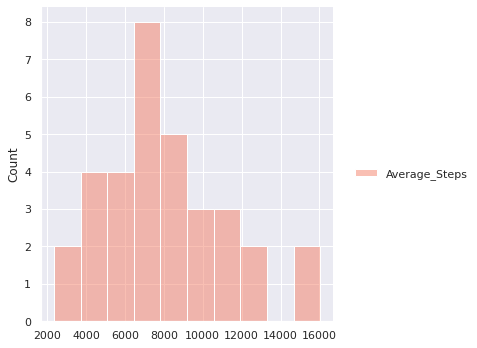

In [22]:
sns.displot(average_steps, bins=10)

Average number of steps is around 7500 steps per person

<AxesSubplot:>

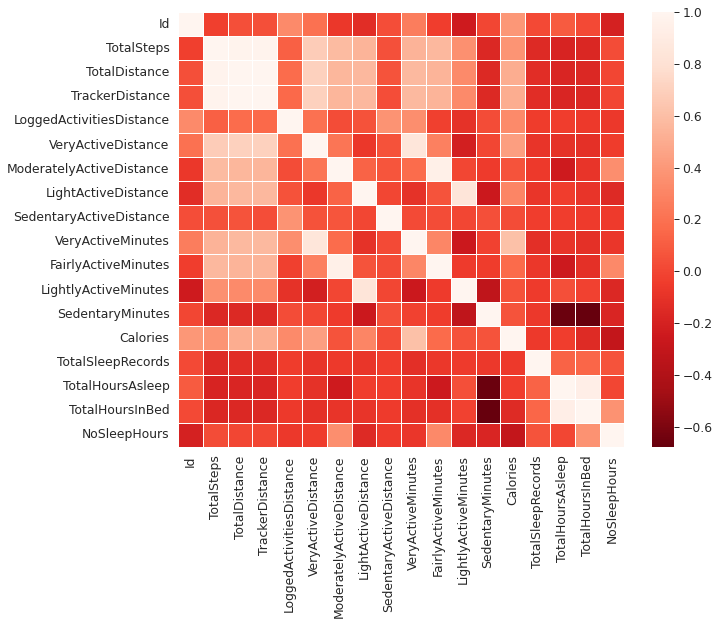

In [23]:
plt.figure(figsize=(10,8), clear=True)
sns.set_context('paper', font_scale=1.4)

cleaned_mx = cleaned_merged_data.corr()

sns.heatmap(cleaned_mx, cmap="Reds_r", linewidths=1)

According to heatmap that shows correlation between values there is strong negative correlation between Setendtary activity and Sleeping hours. Let's check it out more precisely:

<AxesSubplot:xlabel='TotalHoursAsleep', ylabel='SedentaryMinutes'>

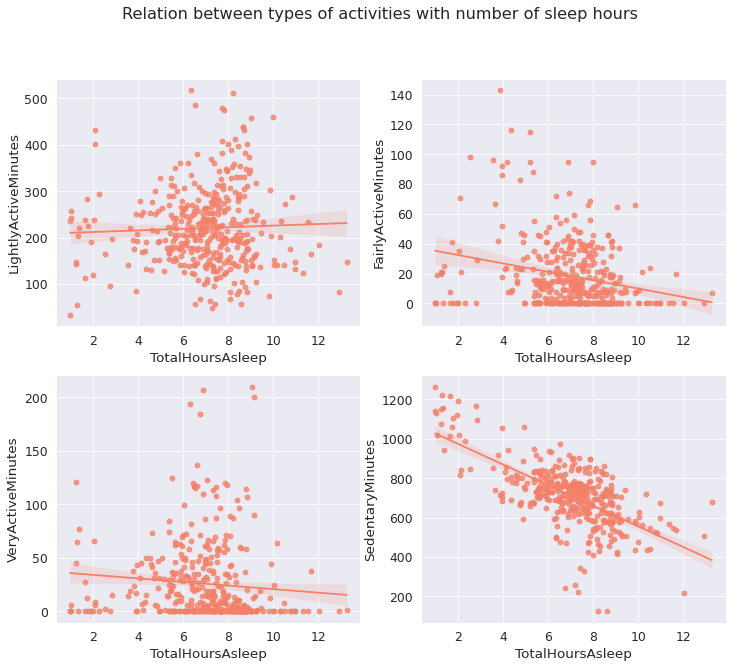

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
fig.suptitle('Relation between types of activities with number of sleep hours')


sns.regplot(data=cleaned_merged_data, x="TotalHoursAsleep", y="LightlyActiveMinutes", ax=axes[0,0])
sns.regplot(data=cleaned_merged_data, x="TotalHoursAsleep", y="FairlyActiveMinutes", ax=axes[0,1])
sns.regplot(data=cleaned_merged_data, x="TotalHoursAsleep", y="VeryActiveMinutes", ax=axes[1,0])
sns.regplot(data=cleaned_merged_data, x="TotalHoursAsleep", y="SedentaryMinutes", ax=axes[1,1])

We can clearly see that all types activities are not affecting sleeping hours except Sedentary activity. There is strong linear relation that shows that the more hours people spent in sedentary category, the worse their sleep was.

In [25]:
average_sleep = pd.DataFrame(cleaned_merged_data.groupby('Id')['TotalHoursAsleep'].agg("mean"))
average_sleep.rename(columns={'TotalHoursAsleep':'Average_sleep'}, inplace=True)

<AxesSubplot:ylabel='Count'>

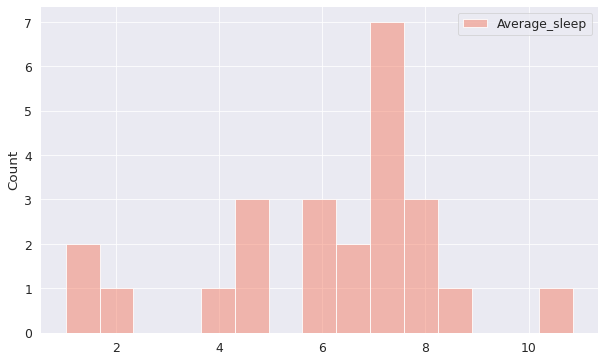

In [26]:
plt.figure(figsize=(10,6))
sns.histplot(average_sleep, bins=15)

The healthy sleep should last from 7 to 9 hours and we can see that most of people are in this range. However there are still a lot of people having lack of sleep.

In [27]:
hourly_intensities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22099 entries, 0 to 22098
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                22099 non-null  int64  
 1   ActivityHour      22099 non-null  object 
 2   TotalIntensity    22099 non-null  int64  
 3   AverageIntensity  22099 non-null  float64
 4   ActivityHours     22099 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 863.4+ KB


<AxesSubplot:xlabel='ActivityHours', ylabel='AverageIntensity'>

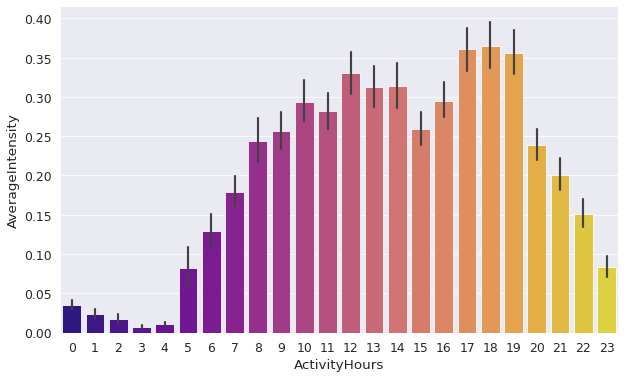

In [28]:
plt.figure(figsize=(10,6))
sns.barplot(data=hourly_intensities, x="ActivityHours", y="AverageIntensity", palette="plasma")

Acccording to the information provided the most active hours are **5-7 PM** and **12-2 PM**

# 6. Act

### Here are some insights:

- Average number of steps is around 7500 steps per day. This number is greater than the one that represents Sedentary lifestyle (<5000). However, a 2020 [study]("https://www.medicalnewstoday.com/articles/how-many-steps-should-you-take-a-day") found that participants who took 8,000 steps per day had a 51% lower riskTrusted Source of dying by any cause compared with those who took 4,000 per day. This trend continued with higher step counts, as participants who took 12,000 steps per day had a 65% lower risk of dying than those who took 4,000. This finding suggests that the benefits of walking increase with step count but also shows that people who cannot reach 10,000 steps in a day can still benefit from the activity.
- Predominant number of sedentary hours causes less hours of sleep. This is proved by [this]("https://pubmed.ncbi.nlm.nih.gov/27830446/") article, that states that "sedentary behavior to be associated with an increased risk of insomnia".
- Speaking of sleep hours, predominant number of people participated in the research have average sleep in the healty range of 7-9 hours. But there is a significant number of people having lack of sleeping hours. This might also be caused by casualities of data collection e.g. some people don't wear device every night.
- The most active hours are 12-2 PM and 5-7 PM. 

### Recommendations

- Share information about their daily steps number through notifications and add recommendations if this number is low or congratulate if this number is higher. 
- Add notifications reminding them to go to sleep at a particular time.
- During most active hours (12-2 PM and 5-7 PM) provide motivational messages via notifications.
- Notify users if their sedentary time exceeds normal amount and remind them that this can cause insomtia.